# Aprendizaje Profundo - Trabajo Práctico 1

Carrera de Especialización en Inteligencia Artificial (CEIA)

Autor: Gonzalo Gabriel Fernandez

## 1. Gradiente Descendente y Adam

In [359]:
import numpy as np
import matplotlib.pyplot as plt

Generación de datos utilizados para el entrenamiento de la neurona que se oprimizará con los algoritmos de gradiente descendente:

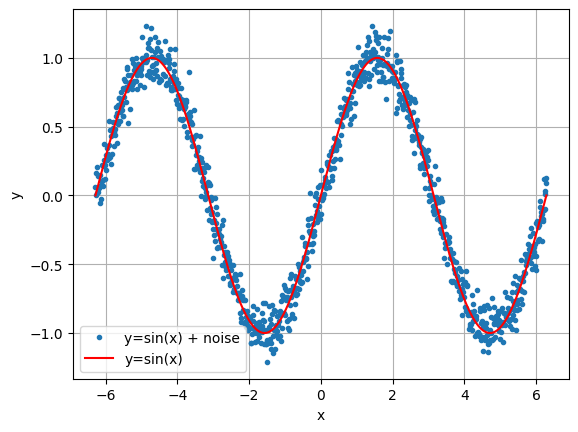

In [360]:
x = np.linspace(-2 * np.pi, 2 * np.pi, 1000).reshape(-1, 1)
y = np.sin(x) + np.random.normal(0, 0.1, x.shape).reshape(-1, 1)
plt.plot(x, y, ".", label="y=sin(x) + noise")
plt.plot(x, np.sin(x), "r-", label="y=sin(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()

El ejercicio propone el trabajar con una red neuronal de una única neurona con una función de activación tangente hiperbólica:

$$
\hat{y} = \tanh(z) = \tanh(w x + b)
$$

La función de costo utilizada es el Error Cuadrático Medio (MSE):

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2
$$

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} ( \tanh(w x_i + b) - y_i )^2
$$

donde $w$ y $b$ son los parámetros a optimizar.

In [361]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))


def mse_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

In [362]:
def single_neuron(theta, X):
    """Single neuron model with activation function hiperbolic tangent."""
    return np.tanh(X @ theta)


def single_neuron_jacobian(theta, X):
    """Jacobian of the single neuron model."""
    z = X @ theta
    return ((1 - np.tanh(z) ** 2) * X).T

### Comparación de Gradiente Descendente y Adam en una Función de Costo No Convexa

In [363]:
compare_result_dict = {"gd": [], "adam": []}
LEARNING_RATES = [0.001, 0.01, 0.1]

### Implementación de Gradiente Descendente

In [364]:
def gradient_descent(
    X,
    y,
    model_fn,
    model_fn_derivative,
    loss_function,
    loss_function_derivative,
    learning_rate=0.01,
    epochs=1000,
    tolerance=1e-05,
    dtype="float",
    random_state=None,
):
    # argument validation
    dtype = np.dtype(dtype)

    X, y = np.asarray(X, dtype=dtype), np.asarray(y, dtype=dtype)
    if X.shape[0] != y.shape[0]:
        raise ValueError("'X' and 'y' lengths do not match")

    learning_rate = np.array(learning_rate, dtype=dtype)
    if np.any(learning_rate <= 0):
        raise ValueError("'learning_rate' must be positive")

    epochs = int(epochs)
    if epochs <= 0:
        raise ValueError("'epochs' must be positive")

    tolerance = np.array(tolerance, dtype=dtype)
    if np.any(tolerance <= 0):
        raise ValueError("'tolerance' must be positive")

    np.random.seed(random_state)

    # gradient descent initialization
    # X extended with ones for theta_0
    X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

    n = X.shape[1]  # model parameters
    m = X.shape[0]  # number of samples
    Y = y.reshape(m, 1)

    # theta initialization
    theta = np.random.randn(n, 1) * 0.01

    loss_history = []

    # gradient descent execution
    for _ in range(epochs):
        h = model_fn(theta, X)
        loss_value = loss_function(Y, h)
        loss_history.append(loss_value)

        errors = loss_function_derivative(Y, h)
        gradient = model_fn_derivative(theta, X) @ errors / m

        theta -= learning_rate * gradient

        # check for convergence
        if np.linalg.norm(loss_value) < tolerance:
            break

    return theta, loss_history

Evaluación del gradiente descendente implementado para distintos learning rate:

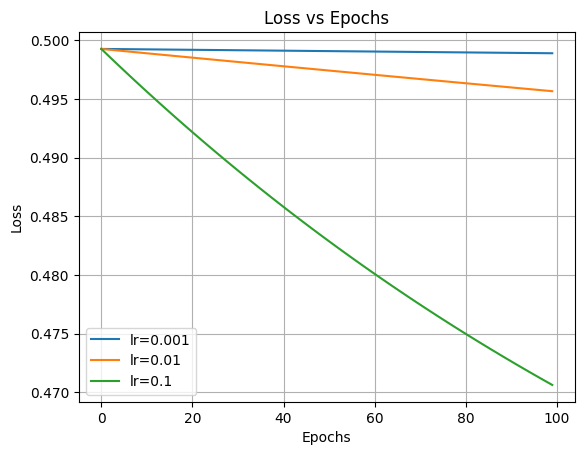

In [365]:
for learning_rate in LEARNING_RATES:
    theta, loss_history = gradient_descent(
        x,
        y,
        model_fn=single_neuron,
        model_fn_derivative=single_neuron_jacobian,
        loss_function=mse,
        loss_function_derivative=mse_derivative,
        learning_rate=learning_rate,
        epochs=100,
        random_state=42,
    )
    plt.plot(loss_history, label=f"lr={learning_rate}")
    compare_result_dict["gd"].append(loss_history)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.grid()

Análisis de predicción para el mejor ajuste del modelo en la evaluación anterior:

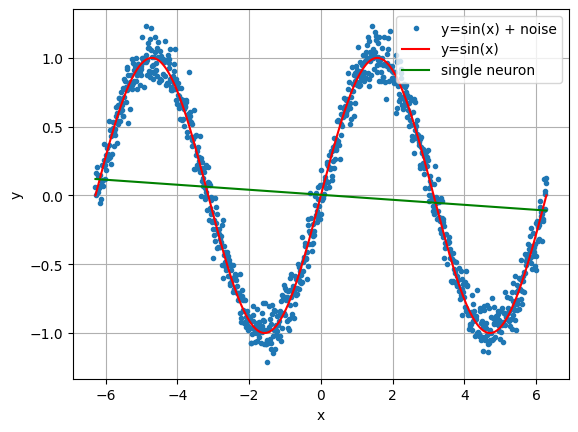

In [366]:
plt.plot(x, y, ".", label="y=sin(x) + noise")
plt.plot(x, np.sin(x), "r-", label="y=sin(x)")
y_hat = single_neuron(theta, np.concatenate((np.ones((x.shape[0], 1)), x), axis=1))
plt.plot(x, y_hat, "g-", label="single neuron")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()

### Implementación de Adam (Adaptive Moment Estimation)

Los "Bias-corrected moments" se obtuvieron del libro "Fundamentals of Deep Learning" capítulo 4 "Beyond Gradient Descent" sección "Adam—Combining Momentum and RMSProp".

In [367]:
def adam(
    X,
    y,
    model_fn,
    model_fn_derivative,
    loss_function,
    loss_function_derivative,
    learning_rate=0.01,
    p1=0.9,
    p2=0.999,
    epsilon=1e-8,
    epochs=1000,
    tolerance=1e-05,
    dtype="float",
    random_state=None,
):
    # argument validation
    dtype = np.dtype(dtype)

    X, y = np.asarray(X, dtype=dtype), np.asarray(y, dtype=dtype)
    if X.shape[0] != y.shape[0]:
        raise ValueError("'X' and 'y' lengths do not match")

    learning_rate = np.array(learning_rate, dtype=dtype)
    if np.any(learning_rate <= 0):
        raise ValueError("'learning_rate' must be positive")

    epochs = int(epochs)
    if epochs <= 0:
        raise ValueError("'epochs' must be positive")

    tolerance = np.array(tolerance, dtype=dtype)
    if np.any(tolerance <= 0):
        raise ValueError("'tolerance' must be positive")

    np.random.seed(random_state)

    # gradient descent initialization
    # X extended with ones for theta_0
    X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

    m_samples, n_features = X.shape
    Y = y.reshape(m_samples, 1)

    # theta initialization
    theta = np.random.randn(n_features, 1) * 0.01

    v = np.zeros_like(theta)  # First moment
    r = np.zeros_like(theta)  # Second moment

    loss_history = []

    # gradient descent execution
    for epoch in range(1, epochs + 1):
        h = model_fn(theta, X)
        loss_value = loss_function(Y, h)
        loss_history.append(loss_value)

        errors = loss_function_derivative(Y, h)
        gradient = model_fn_derivative(theta, X) @ errors / m_samples

        # Update biased first moment estimate
        v = p1 * v + (1 - p1) * gradient
        # Update biased second moment estimate
        r = p2 * r + (1 - p2) * (gradient**2)

        # Bias-corrected moments
        v_hat = v / (1 - p1)
        r_hat = r / (1 - p2)

        # epsilon prevents division by zero
        theta -= learning_rate * v_hat / (np.sqrt(r_hat) + epsilon)

        # check for convergence
        if np.linalg.norm(loss_value) < tolerance:
            break

    return theta, loss_history

Evaluación del algoritmo Adam implementado para distintos learning rate:

In [368]:
for learning_rate in LEARNING_RATES:
    theta, loss_history = adam(
        x,
        y,
        model_fn=single_neuron,
        model_fn_derivative=single_neuron_jacobian,
        loss_function=mse,
        loss_function_derivative=mse_derivative,
        learning_rate=learning_rate,
        epochs=100,
        random_state=42,
    )
    compare_result_dict["adam"].append(loss_history)

Comparación del resultado y rendimiento de Adam y GD para cada learning rate:

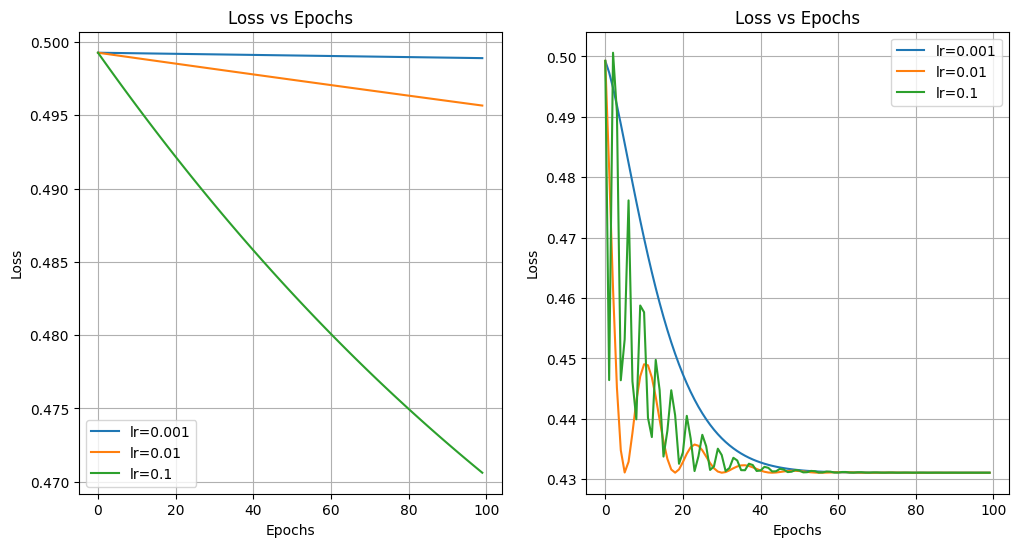

In [369]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for learning_rate, gd_data, adam_data in zip(
    LEARNING_RATES, compare_result_dict["gd"], compare_result_dict["adam"]
):
    axs[0].plot(gd_data, label=f"lr={learning_rate}")
    axs[1].plot(adam_data, label=f"lr={learning_rate}")
axs[0].set_title("Gradient Descent Loss vs Epochs")
axs[1].set_title("Adam Loss vs Epochs")
for ax in axs:
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("Loss vs Epochs")
    ax.grid()

Conclusiones de la comparación entre GD y Adam para distintos learning rates:
- En general, Adam tiene una convergencia mucho más rápida que GD (alrededor de 50 epochs)
- En general, a los 100 epochs Adam converge a un valor de costo menor que GD (0.43 contra 0.47)
- Tanto para GD como para Adam, un incremento en el learning rate aumenta la velocidad de convergencia hacia el mínimo de la función de costo.
- En Adam se observa como un incremento en el learning rate produce oscilaciones en la optimización con una amplitud y frecuencia que parece ser proporcional al learning rate.

## 2. Entrenamiento y benchmark de diferentes modelos

In [402]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

El dataset contiene información sobre las transacciones y el objetivo es poder utilizarlo para crear diferentes modelos que puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro.

**Objetivo:** Clasificar los clientes en las siguientes categorías:
- "Casual" (gasta menos de 5000)
- "Gama media" (gasta entre 5000 y 10000)
- "Fiel" (gasta entre 10000 y 15000)
- "Premium" (gasta más de 15000)

### EDA y preparación del dataset

Carga del dataset a analizar y primeras estadíasticas:

In [435]:
df = pd.read_csv("data/dataset_black_sales.csv")
print("Número de observaciones:", len(df))
df.head()

Número de observaciones: 550068


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


Análisis de las variables del dataset:
- User ID: identificador del cliente
- Product ID: identificador del producto adquirido por el cliente
- Gender: Sexo del cliente (categórica)
- Age: Edad en rangos predefinidos
- Occupation: Empleo del cliente (categórica)
- City Category: Categoría de la ciudad (A, B o C)  (categórica)
- Stay In Current City Years: Cantidad de años que el cliente lleva en la ciudad
- Marital Status: Estado civil del cliente  (categórica)
- Product Category 1: Categoría del producto adquirido  (categórica)
- Product Category 2: Categoría del producto adquirido (si más de una)  (categórica)
- Product Category 3: Categoría del producto adquirido (si más de dos)  (categórica)
- Purchase: Monto de la compra

In [436]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [437]:
print("Número de observaciones:", len(df))
print("Número de clientes únicos:", df["User_ID"].nunique())

Número de observaciones: 550068
Número de clientes únicos: 5891


Se puede observar que de las 550068 observaciones solo hay 5891 clientes únicos, por lo que el dataset cuenta con compras de más de una compra por cliente.

El objetivo es clasificar los clientes en base a "cuánto gastan". Esto significa que las entradas del modelo de clasificación serán las variables que describen el cliente, que son:
- Sexo
- Edad
- Ocupación
- Categoría de la ciudad donde habita
- Cantidad de años del cliente en la ciudad
- Estado cívico

También se considera que el "cuánto gasta" es el promedio del gasto en todas las compras del cliente*. Esto implica que se procesa el dataset para reducirlo en las variables mencionadas previamente y el promedio de todas las compras de cada cliente.

En esta reducción del dataset las variables vinculadas a los productos adquiridos dejan de ser relevantes para el análisis.

*\*Podría utilizarse el total de las compras del cliente, pero el promedio permite ubicar los valores dentro del rango propuesto en la consigna*.

In [439]:
user_df = df.drop(
    # ["Product_ID", "Product_Category_1", "Product_Category_2", "Product_Category_3"],
    ["User_ID", "Product_ID", "Product_Category_1", "Product_Category_2", "Product_Category_3"],
    axis=1,
)
# user_df = user_df.groupby("User_ID").agg(
#     {
#         "Purchase": "mean",
#         "Gender": "first",
#         "Age": "first",
#         "Occupation": "first",
#         "City_Category": "first",
#         "Stay_In_Current_City_Years": "first",
#         "Marital_Status": "first",
#     }
# )
user_df.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase
0,F,0-17,10,A,2,0,8370
1,F,0-17,10,A,2,0,15200
2,F,0-17,10,A,2,0,1422
3,F,0-17,10,A,2,0,1057
4,M,55+,16,C,4+,0,7969


Para el modelo de clasificación, se realiza un binning sobre el gasto de los clientes de acuerdo a los rangos propuestos inicialmente.

In [440]:
bins = [float("-inf"), 5000, 10000, 15000, float("inf")]
labels = ["Casual", "Gama_Media", "Fiel", "Premium"]
user_df["Purchase"] = pd.cut(user_df["Purchase"], bins=bins, labels=labels)

Chequeo de datos nulos:

In [441]:
print("Número de datos con valores nulos:")
print(user_df.isnull().sum())

Número de datos con valores nulos:
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Purchase                      0
dtype: int64


Chequeo de datos duplicados:

In [442]:
print("Número de datos duplicados:", user_df.duplicated().sum())
# user_df = user_df.drop_duplicates()
print("Número de observaciones:", len(user_df))

Número de datos duplicados: 540465
Número de observaciones: 550068


A continuación se realiza un análisis de la distribución de cada variable:

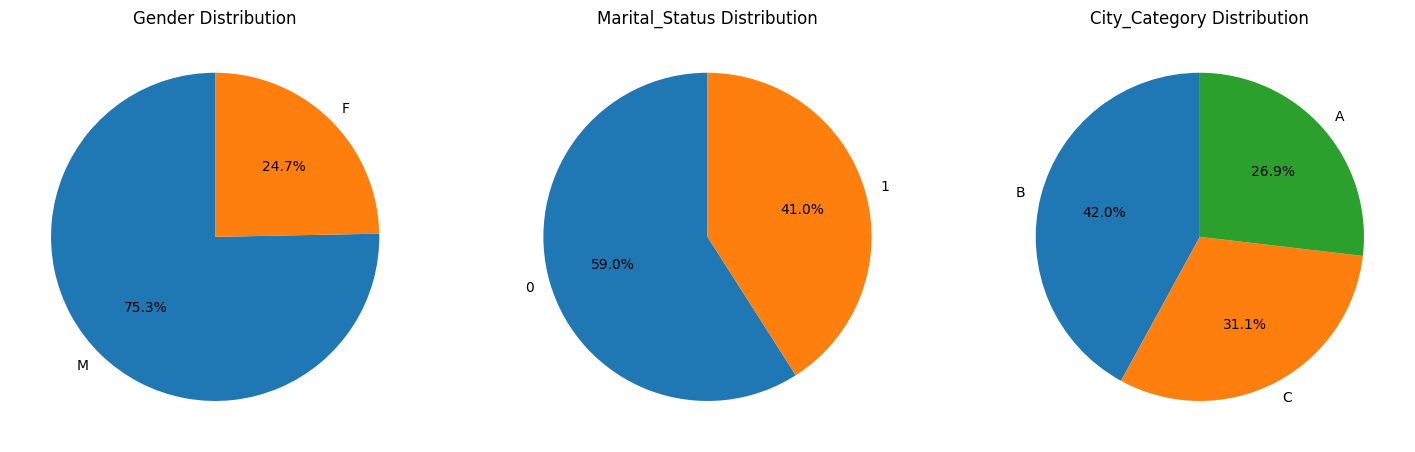

In [443]:
pie_chart_labels = ["Gender", "Marital_Status", "City_Category"]

fig, axes = plt.subplots(
    1, len(pie_chart_labels), figsize=(6 * len(pie_chart_labels), 6)
)

for i, label in enumerate(pie_chart_labels):
    data_counts = user_df[label].value_counts()
    axes[i].pie(data_counts, labels=data_counts.index, autopct="%1.1f%%", startangle=90)
    axes[i].set_title(label + " Distribution")

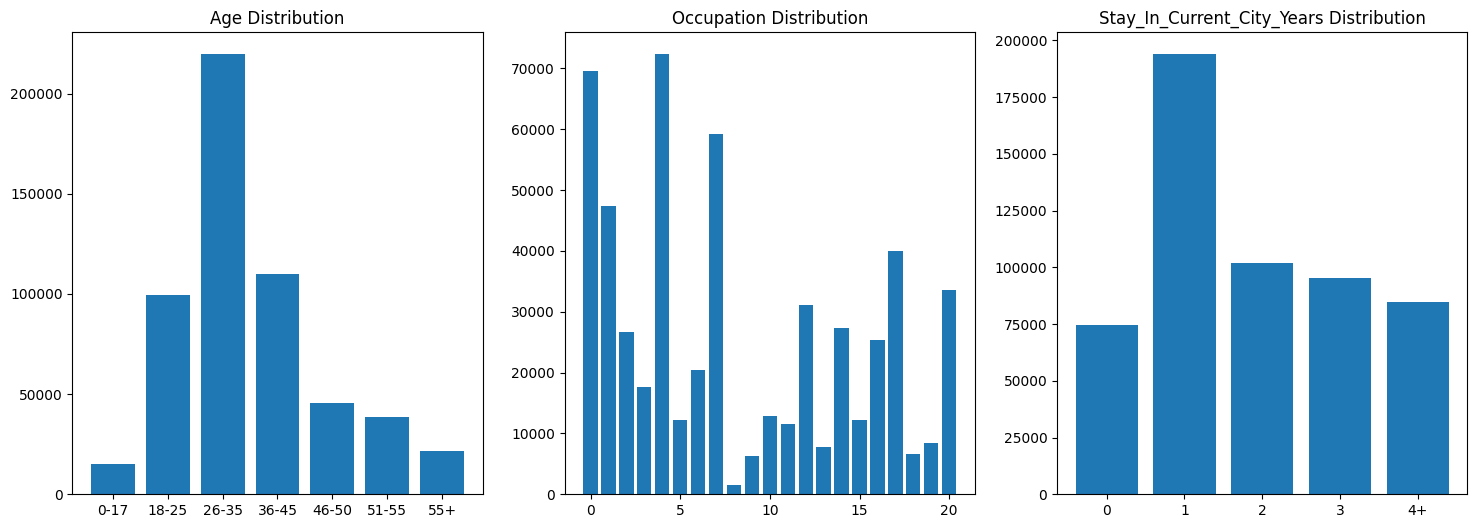

In [444]:
bar_chart_labels = ["Age", "Occupation", "Stay_In_Current_City_Years"]

fig, axes = plt.subplots(
    1, len(bar_chart_labels), figsize=(6 * len(bar_chart_labels), 6)
)

for i, label in enumerate(bar_chart_labels):
    data_counts = user_df[label].value_counts().sort_index()
    axes[i].bar(data_counts.index, data_counts.values)
    axes[i].set_title(label + " Distribution")

Análisis de la distribución de la variable objetivo:

Text(0.5, 1.0, 'Purchase Distribution')

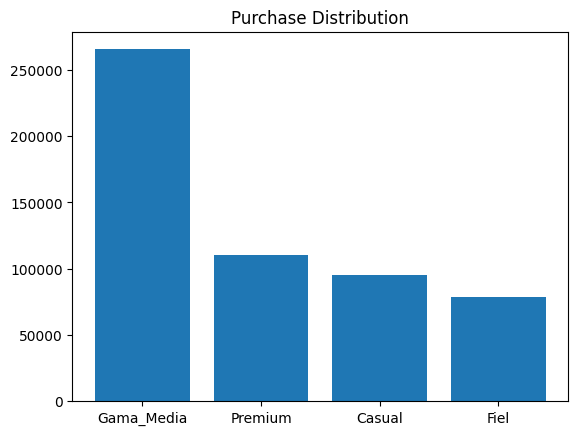

In [445]:
purchase_counts = user_df["Purchase"].value_counts()
plt.bar(purchase_counts.index, purchase_counts.values)
plt.title("Purchase Distribution")

Conclusiones de EDA:
- Hay predominancia de hombres en las observaciones del dataset.
- No se definen los valores de estado cívico, la categoría 0 predomina sobre la 1.
- Todas las categorías de ciudad se encuentran bien representadas en el dataset
- Se observa una distribución normal en las edades de los clientes, con centro en las edades 26 a 35 años.
- Hay gran variación en la representación de las ocupaciones.
- Hay predominancia en clientes con un año en la ciudad.

Hay un claro desbalance en clases al abservar la distribución de la variable objetivo. Con muchas más observaciones de clientes "Gama Media" y "Fiel" que de "Premium" y "Casual". Por este motivo se utilizará la librería `imbalanced-learn` a la hora de entrenar el modelo.

Se realiza un encoding de las variables categóricas.

- Las variables "Gender" y "Marital_Status" son binarias.
- La variable "Stay_In_Current_City_Years" es ordinaria, y solo se reemplaza "4+" por 4 para tratarla como tal.
- Para la variable "Age" se decide preservar el orden en lugar de tratarla como variable categórica. Por los tantos se le asigna un valor a cada rango de edad.
- A las variables categóricas "City_Category" y "Occupation" se les aplica un One-Hot encoding.
- A la variable target "Purchase" se le aplica un encoding para colocar una representación numérica a cada etiqueta.

In [446]:
encoder = LabelEncoder()

user_df["Gender"] = encoder.fit_transform(user_df["Gender"]).astype(bool)
user_df["Marital_Status"] = encoder.fit_transform(user_df["Marital_Status"]).astype(
    bool
)
user_df["Stay_In_Current_City_Years"] = (
    user_df["Stay_In_Current_City_Years"].replace("4+", 4).astype(int)
)
user_df["Age"] = user_df["Age"].map(
    {
        "0-17": 0,
        "18-25": 1,
        "26-35": 2,
        "36-45": 3,
        "46-50": 4,
        "51-55": 5,
        "55+": 6,
    }
)
user_df = pd.get_dummies(user_df, columns=["City_Category"], drop_first=True)
user_df = pd.get_dummies(user_df, columns=["Occupation"], drop_first=True)
user_df["Purchase"] = encoder.fit_transform(user_df["Purchase"])
user_df.head()

,Gender,Age,Stay_In_Current_City_Years,Marital_Status,Purchase,City_Category_B,City_Category_C,Occupation_1,Occupation_2,Occupation_3,...,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20
0,False,0,2,False,2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,0,2,False,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,0,2,False,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,0,2,False,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,6,4,False,2,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False


### Benchmark de modelos de ML clásico

División del dataset en features y target.

In [447]:
X = user_df.drop("Purchase", axis=1).values
y = user_df["Purchase"].values

Normalización de los datos y división del dataset en train y test. Resampling de los datos de entrenamiento dado el desbalance de clases en la variable target.

In [448]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

Entrenamiento y evaluación de regresión logística para benchmark:

              precision    recall  f1-score   support

           0       0.20      0.39      0.26     18985
           1       0.16      0.12      0.14     15785
           2       0.53      0.24      0.33     53139
           3       0.24      0.41      0.30     22105

    accuracy                           0.28    110014
   macro avg       0.28      0.29      0.26    110014
weighted avg       0.36      0.28      0.28    110014



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

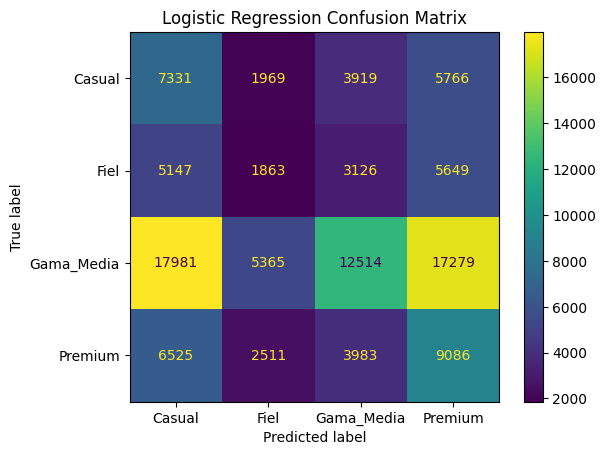

In [449]:
clf_lr = LogisticRegression()
clf_lr.fit(X_res, y_res)
y_pred = clf_lr.predict(X_test)
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=encoder.classes_)
disp.plot()
plt.title("Logistic Regression Confusion Matrix")

Entrenamiento y evaluación de un modelo con Random Forest para benchmark:

              precision    recall  f1-score   support

           0       0.25      0.42      0.31     18985
           1       0.18      0.21      0.19     15785
           2       0.57      0.27      0.37     53139
           3       0.28      0.42      0.33     22105

    accuracy                           0.32    110014
   macro avg       0.32      0.33      0.30    110014
weighted avg       0.40      0.32      0.33    110014



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

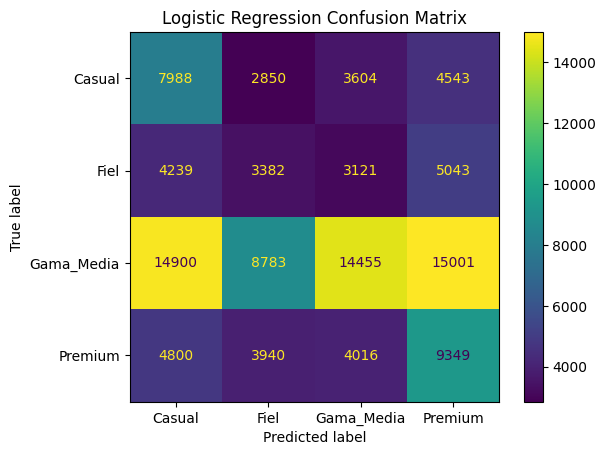

In [450]:
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_res, y_res)
y_pred = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=encoder.classes_)
disp.plot()
plt.title("Random Forest Confusion Matrix")

Entrenamiento y evaluación de un modelo con Random Forest de `imbalance-learn` específicamente para problemas con desbalance de clases:

              precision    recall  f1-score   support

           0       0.25      0.42      0.31     18985
           1       0.18      0.22      0.20     15785
           2       0.58      0.27      0.36     53139
           3       0.28      0.42      0.34     22105

    accuracy                           0.32    110014
   macro avg       0.32      0.33      0.30    110014
weighted avg       0.40      0.32      0.33    110014



Text(0.5, 1.0, 'Balanced Random Forest Confusion Matrix')

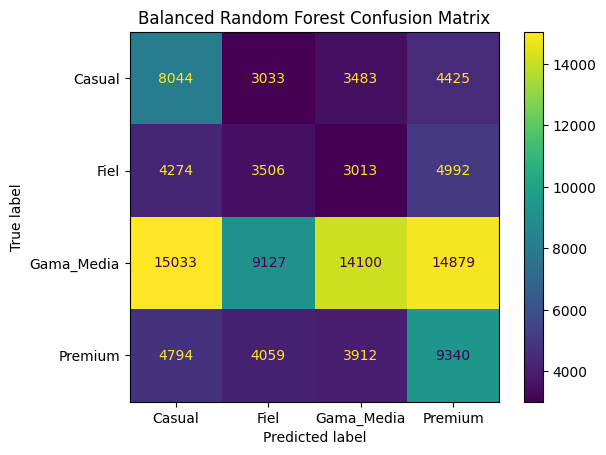

In [451]:
clf_brf = BalancedRandomForestClassifier(random_state=42)
clf_brf.fit(X_train, y_train)
y_pred = clf_brf.predict(X_test)
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=encoder.classes_)
disp.plot()
plt.title("Balanced Random Forest Confusion Matrix")

### Modelo con deep learning sin embeddings

Creación del dataset para PyTorch:

In [ ]:
class BlackFridayDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = BlackFridayDataset(X_res, y_res)
test_dataset = BlackFridayDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

Definición de la red neuronal sin embeddings:

In [453]:
class ClientClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)


model = ClientClassifier(input_dim=X.shape[1], output_dim=len(encoder.classes_))

In [433]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 100

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/100, Loss: 0.9926
Epoch 2/100, Loss: 0.6178
Epoch 3/100, Loss: 0.5127
Epoch 4/100, Loss: 0.4681
Epoch 5/100, Loss: 0.4475
Epoch 6/100, Loss: 0.4308
Epoch 7/100, Loss: 0.4203
Epoch 8/100, Loss: 0.4172
Epoch 9/100, Loss: 0.4089
Epoch 10/100, Loss: 0.4051
Epoch 11/100, Loss: 0.3981
Epoch 12/100, Loss: 0.3960
Epoch 13/100, Loss: 0.3959
Epoch 14/100, Loss: 0.3907
Epoch 15/100, Loss: 0.3905
Epoch 16/100, Loss: 0.3867
Epoch 17/100, Loss: 0.3856
Epoch 18/100, Loss: 0.3888
Epoch 19/100, Loss: 0.3856
Epoch 20/100, Loss: 0.3864
Epoch 21/100, Loss: 0.3802
Epoch 22/100, Loss: 0.3791
Epoch 23/100, Loss: 0.3772
Epoch 24/100, Loss: 0.3784
Epoch 25/100, Loss: 0.3754
Epoch 26/100, Loss: 0.3753
Epoch 27/100, Loss: 0.3761
Epoch 28/100, Loss: 0.3744
Epoch 29/100, Loss: 0.3731
Epoch 30/100, Loss: 0.3707
Epoch 31/100, Loss: 0.3730
Epoch 32/100, Loss: 0.3722
Epoch 33/100, Loss: 0.3670
Epoch 34/100, Loss: 0.3664
Epoch 35/100, Loss: 0.3679
Epoch 36/100, Loss: 0.3644
Epoch 37/100, Loss: 0.3646
Epoch 38/1

Classification Report:
               precision    recall  f1-score   support

      Casual       0.00      0.00      0.00         5
      Medium       0.43      0.50      0.46       423
      Trusty       0.69      0.61      0.64       740
     Premium       0.03      0.09      0.05        11

    accuracy                           0.56      1179
   macro avg       0.29      0.30      0.29      1179
weighted avg       0.59      0.56      0.57      1179



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

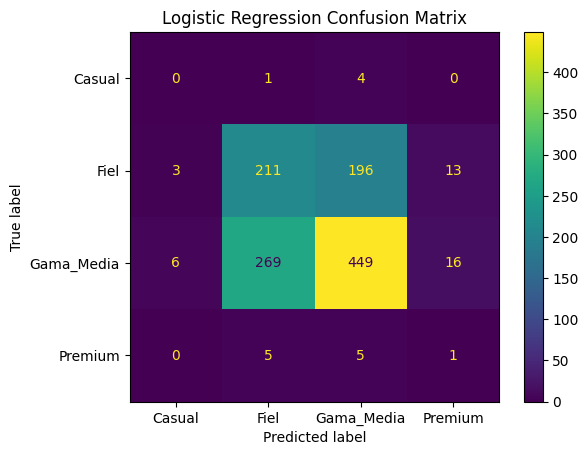

In [434]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=['Casual', 'Medium', 'Trusty', 'Premium']))
disp = ConfusionMatrixDisplay(confusion_matrix(all_labels, all_preds), display_labels=encoder.classes_)
disp.plot()
plt.title("Logistic Regression Confusion Matrix")